# Задание 7-8: Работа со стратегиями сэмплинга в условиях несбалансированности классов
*Выполнено студенткой группы ИММО-01-25 Чан Минь Ханг*

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
BOLD = "\033[1m"
RESET = "\033[0m"

*Набор данных: https://archive.ics.uci.edu/dataset/104/university*

In [3]:
df = pd.read_csv('university.csv')
df

,name,state,control,no_of_students,male:female_ratio,student:faculty_ratio,sat_verbal,sat_math,expenses,percent_financial_aid,...,percent_admittance,percent_enrolled,academics_scale,social_scale,quality_of_life_scale,academic_emphasis,location,colors,mascot,religious_backing
0,ADELPHI,NEWYORK,PRIVATE,0-5000,30:70,15:1,500.0,475.0,7000-10000,60.0,...,70.0,40.0,2.0,2.0,2.0,"business-administration, biology",NaN,NaN,NaN,NaN
1,ARIZONA-STATE,ARIZONA,STATE,20000+,50:50,20:1,450.0,500.0,0-4000,50.0,...,80.0,60.0,3.0,4.0,5.0,"business-education, engineering, accounting, f...",NaN,NaN,NaN,NaN
2,BOSTON-COLLEGE,MASSACHUSETTS,PRIVATE:ROMAN-CATHOLIC,0-5000,40:60,20:1,500.0,550.0,10000+,60.0,...,50.0,40.0,4.0,5.0,3.0,"economics, biology, english",SUBURBAN,NaN,NaN,NaN
3,BOSTON-UNIVERSITY,MASSACHUSETTS,PRIVATE,10000-15000,45:55,12:1,550.0,575.0,10000+,60.0,...,60.0,40.0,4.0,4.0,3.0,"business-administration, psychology, liberal-arts",URBAN,NaN,NaN,NaN
4,BROWN,RHODEISLAND,PRIVATE,0-5000,50:50,11:1,625.0,650.0,10000+,40.0,...,20.0,50.0,5.0,4.0,5.0,"biology, history, arts-sciences",URBAN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,ORAL-ROBERTS-UNIVERSITY,OKLAHOMA,PRIVATE,0-5000,1:1,11:1,463.0,490.0,0-4000,70.0,...,65.0,75.0,4.0,2.0,3.0,"business-administration, education, fine-and-p...",SUBURBAN,NaN,NaN,NaN
281,UNIVERSITY-OF-TULSA,OKLAHOMA,PRIVATE,0-5000,3:2,16:1,471.0,520.0,0-4000,75.0,...,85.0,65.0,4.0,4.0,4.0,"area-studies, business-administration, educati...",URBAN,NaN,NaN,NaN
282,CONNECTICUT-COLLEGE,CONNECTICUT,PRIVATE,0-5000,35:65,10:1,550.0,575.0,10000+,30.0,...,40.0,40.0,4.0,3.0,4.0,liberal-arts,SMALL-CITY,NaN,NaN,NaN
283,LEHIGH-UNIVERSITY,PENNSYLVANIA,PRIVATE,0-5000,75:25,10:1,550.0,650.0,7000-10000,45.0,...,50.0,40.0,4.0,4.0,2.0,"engineering, physical",SMALL-CITY,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   285 non-null    object 
 1   state                  285 non-null    object 
 2   control                282 non-null    object 
 3   no_of_students         285 non-null    object 
 4   male:female_ratio      285 non-null    object 
 5   student:faculty_ratio  263 non-null    object 
 6   sat_verbal             263 non-null    float64
 7   sat_math               263 non-null    float64
 8   expenses               285 non-null    object 
 9   percent_financial_aid  273 non-null    float64
 10  no_applicants          279 non-null    object 
 11  percent_admittance     280 non-null    float64
 12  percent_enrolled       281 non-null    float64
 13  academics_scale        277 non-null    float64
 14  social_scale           277 non-null    float64
 15  qualit

In [5]:
target = 'academics_scale'
print("Целевая переменная:", target)
print("Количество классов:", df[target].nunique())
print("Распределение классов:")
print(df[target].value_counts().sort_index())

df = df.dropna(subset=[target])

Целевая переменная: academics_scale
Количество классов: 5
Распределение классов:
1.0     7
2.0    33
3.0    99
4.0    95
5.0    43
Name: academics_scale, dtype: int64


In [6]:
text_cols = ['name', 'state', 'control', 'location', 
             'colors', 'mascot', 'religious_backing', 
             'academic_emphasis']
df = df.drop(columns=[col for col in text_cols if col in df.columns], 
             errors='ignore')

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
X = df.drop(columns=[target])
y = df[target]

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размеры выборок:")
print(f"\tОбучающая: {X_train.shape}")
print(f"\tТестовая:  {X_test.shape}")

print(f"\nРаспределение классов в обучающей выборке:")
print(pd.Series(y_train).value_counts().sort_index())

print(f"\nРаспределение классов в тестовой выборке:")
print(pd.Series(y_test).value_counts().sort_index())

Размеры выборок:
	Обучающая: (221, 12)
	Тестовая:  (56, 12)

Распределение классов в обучающей выборке:
1.0     6
2.0    26
3.0    79
4.0    76
5.0    34
Name: academics_scale, dtype: int64

Распределение классов в тестовой выборке:
1.0     1
2.0     7
3.0    20
4.0    19
5.0     9
Name: academics_scale, dtype: int64


## Применение алгоритмов балансировки классов
Применить к набору данных алгоритмы балансировки классов: 
- SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#), 
- borderline-SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html) 
- borderline-SMOTE2 (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html). 

In [7]:
def apply_oversampling(X_train, y_train, method='smote', random_state=42):
    method_names = {
        'smote': "SMOTE",
        'borderline1': "Borderline-SMOTE1",
        'borderline2': "Borderline-SMOTE2"
    }
    
    print(f"\n{BOLD}БАЛАНСИРОВКА КЛАССОВ {method_names[method]}{RESET}")
    
    if method == 'smote':
        oversampler = SMOTE(random_state=random_state)
    elif method in ['borderline1', 'borderline2']:
        kind = 'borderline-1' if method == 'borderline1' else 'borderline-2'
        oversampler = BorderlineSMOTE(kind=kind, random_state=random_state)
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    
    print(f"Размер после балансировки: {X_resampled.shape}")
    print(f"Распределение классов после балансировки:")
    print(pd.Series(y_resampled).value_counts().sort_index())
    
    return X_resampled, y_resampled

In [8]:
X_train_smote, y_train_smote = apply_oversampling(
    X_train, y_train, method='smote')

X_train_bsmote1, y_train_bsmote1 = apply_oversampling(
    X_train, y_train, method='borderline1')

X_train_bsmote2, y_train_bsmote2 = apply_oversampling(
    X_train, y_train, method='borderline2')


БАЛАНСИРОВКА КЛАССОВ SMOTE
Размер после балансировки: (395, 12)
Распределение классов после балансировки:
1.0    79
2.0    79
3.0    79
4.0    79
5.0    79
Name: academics_scale, dtype: int64

БАЛАНСИРОВКА КЛАССОВ Borderline-SMOTE1
Размер после балансировки: (395, 12)
Распределение классов после балансировки:
1.0    79
2.0    79
3.0    79
4.0    79
5.0    79
Name: academics_scale, dtype: int64

БАЛАНСИРОВКА КЛАССОВ Borderline-SMOTE2
Размер после балансировки: (395, 12)
Распределение классов после балансировки:
1.0    79
2.0    79
3.0    79
4.0    79
5.0    79
Name: academics_scale, dtype: int64


## Разработка классификаторов с балансировкой
Разработать для сбалансированных наборов данных SVM-, knn-, RF- классификаторы. 

Выбрать лучшие классификаторы. Выдвинуть гипотезу о том, какой трёх из алгоритмов балансировки оказался лучшим для рассматриваемого набора данных. 
         
Сравнить классификаторы на основе показателей качества классификации до и после балансировки. 


In [9]:
def evaluate_classifier(y_true, y_pred, model_name=""):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"{model_name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    labels = np.unique(np.concatenate([y_true, y_pred]))
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', 
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return acc, rec, prec, f1


def apply_classifier(X_train_balanced, y_train_balanced, X_test, y_test, method_name, model_type='svm'):
    model_configs = {
        'svm': {
            'class': SVC,
            'params': {'random_state': 42, 'probability': True},
            'param_grid': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            },
            'name': 'SVM',
            'additional_info': lambda model: f"Количество опорных векторов: {model.support_.shape[0]}"
        },
        'knn': {
            'class': KNeighborsClassifier,
            'params': {},
            'param_grid': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            },
            'name': 'KNN',
            'additional_info': lambda model: None
        },
        'rf': {
            'class': RandomForestClassifier,
            'params': {'random_state': 42},
            'param_grid': {
                'n_estimators': [50, 100],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5]
            },
            'name': 'Random Forest',
            'additional_info': lambda model: None
        }
    }
    
    config = model_configs[model_type]
    model_name = config['name']
    
    method_label = "без балансировки" if method_name == "Original" else f"c {method_name}"
    print(f"\n{BOLD}{model_name} {method_label}{RESET}")
    
    model = config['class'](**config['params'])
    grid_search = GridSearchCV(model, config['param_grid'], 
                               cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    best_model = grid_search.best_estimator_
    print(f"Лучшие параметры {model_name}: {grid_search.best_params_}")
    
    additional_info = config['additional_info'](best_model)
    if additional_info:
        print(additional_info)
    
    y_train_pred = best_model.predict(X_train_balanced)
    print("\nОценка на обучающей выборке:")
    train_metrics = evaluate_classifier(y_train_balanced, y_train_pred,
                                        f"{model_name} Train ({method_name})")
    
    y_test_pred = best_model.predict(X_test)
    print("\nОценка на тестовой выборке:")
    test_metrics = evaluate_classifier(y_test, y_test_pred, 
                                       f"{model_name} Test ({method_name})")
    
    return best_model, train_metrics, test_metrics


SVM без балансировки
Лучшие параметры SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Количество опорных векторов: 182

Оценка на обучающей выборке:
SVM Train (Original):
  Accuracy:  0.9321
  Recall:    0.9321
  Precision: 0.9319
  F1-score:  0.9320
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6
         2.0       0.92      0.92      0.92        26
         3.0       0.92      0.91      0.92        79
         4.0       0.92      0.92      0.92        76
         5.0       0.97      1.00      0.99        34

    accuracy                           0.93       221
   macro avg       0.95      0.95      0.95       221
weighted avg       0.93      0.93      0.93       221



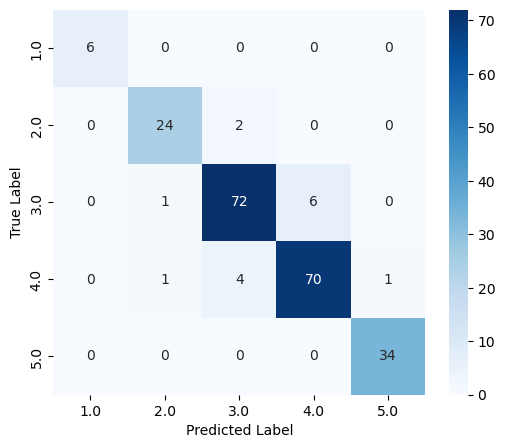


Оценка на тестовой выборке:
SVM Test (Original):
  Accuracy:  0.6429
  Recall:    0.6429
  Precision: 0.6096
  F1-score:  0.6233
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.25      0.14      0.18         7
         3.0       0.59      0.65      0.62        20
         4.0       0.71      0.79      0.75        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.64        56
   macro avg       0.47      0.47      0.47        56
weighted avg       0.61      0.64      0.62        56



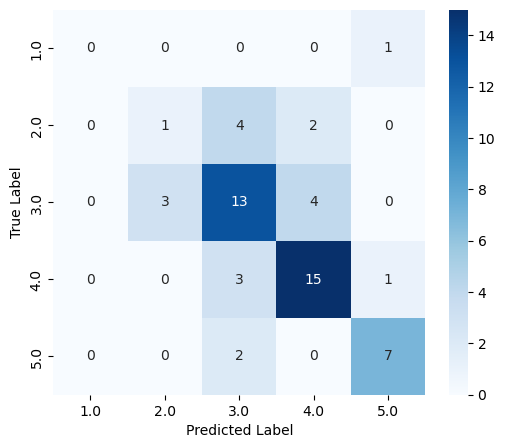


SVM c SMOTE
Лучшие параметры SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Количество опорных векторов: 229

Оценка на обучающей выборке:
SVM Train (SMOTE):
  Accuracy:  0.9772
  Recall:    0.9772
  Precision: 0.9771
  F1-score:  0.9771
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       0.98      1.00      0.99        79
         3.0       0.96      0.95      0.96        79
         4.0       0.96      0.94      0.95        79
         5.0       0.99      1.00      0.99        79

    accuracy                           0.98       395
   macro avg       0.98      0.98      0.98       395
weighted avg       0.98      0.98      0.98       395



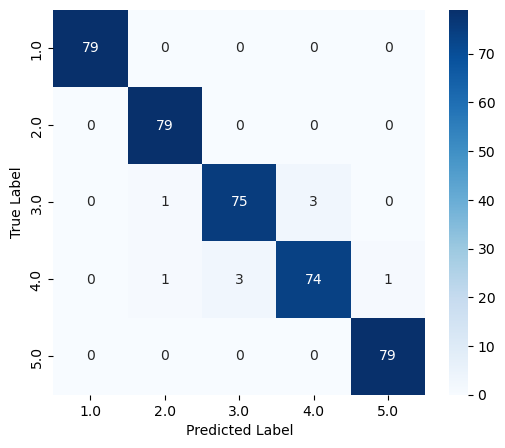


Оценка на тестовой выборке:
SVM Test (SMOTE):
  Accuracy:  0.6607
  Recall:    0.6607
  Precision: 0.6351
  F1-score:  0.6447
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.25      0.14      0.18         7
         3.0       0.65      0.65      0.65        20
         4.0       0.73      0.84      0.78        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.66        56
   macro avg       0.48      0.48      0.48        56
weighted avg       0.64      0.66      0.64        56



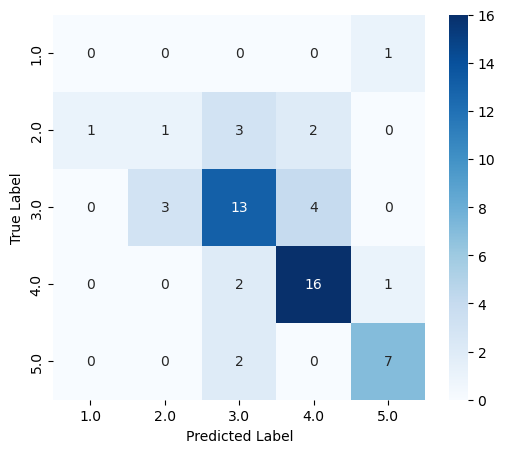


SVM c Borderline-SMOTE1
Лучшие параметры SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Количество опорных векторов: 238

Оценка на обучающей выборке:
SVM Train (Borderline-SMOTE1):
  Accuracy:  0.9797
  Recall:    0.9797
  Precision: 0.9798
  F1-score:  0.9797
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      0.99      0.99        79
         3.0       0.95      0.96      0.96        79
         4.0       0.96      0.95      0.96        79
         5.0       0.99      1.00      0.99        79

    accuracy                           0.98       395
   macro avg       0.98      0.98      0.98       395
weighted avg       0.98      0.98      0.98       395



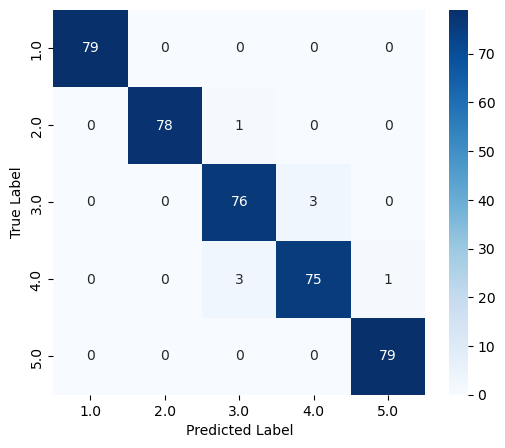


Оценка на тестовой выборке:
SVM Test (Borderline-SMOTE1):
  Accuracy:  0.6429
  Recall:    0.6429
  Precision: 0.6197
  F1-score:  0.6287
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.25      0.14      0.18         7
         3.0       0.62      0.65      0.63        20
         4.0       0.71      0.79      0.75        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.64        56
   macro avg       0.47      0.47      0.47        56
weighted avg       0.62      0.64      0.63        56



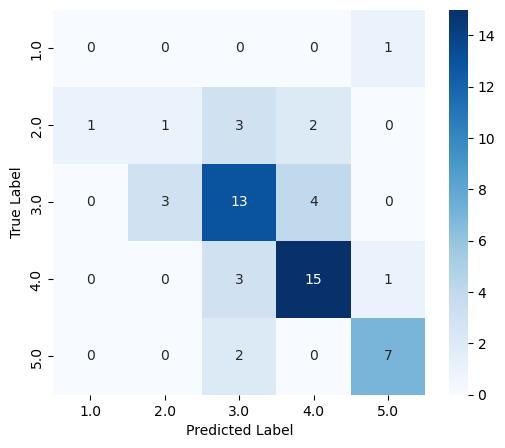


SVM c Borderline-SMOTE2
Лучшие параметры SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Количество опорных векторов: 223

Оценка на обучающей выборке:
SVM Train (Borderline-SMOTE2):
  Accuracy:  0.9772
  Recall:    0.9772
  Precision: 0.9772
  F1-score:  0.9771
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       0.99      0.99      0.99        79
         3.0       0.95      0.96      0.96        79
         4.0       0.96      0.94      0.95        79
         5.0       0.99      1.00      0.99        79

    accuracy                           0.98       395
   macro avg       0.98      0.98      0.98       395
weighted avg       0.98      0.98      0.98       395



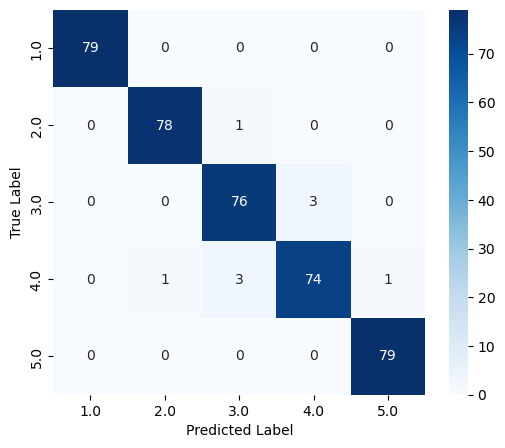


Оценка на тестовой выборке:
SVM Test (Borderline-SMOTE2):
  Accuracy:  0.6429
  Recall:    0.6429
  Precision: 0.6072
  F1-score:  0.6221
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.25      0.14      0.18         7
         3.0       0.62      0.65      0.63        20
         4.0       0.71      0.79      0.75        19
         5.0       0.70      0.78      0.74         9

    accuracy                           0.64        56
   macro avg       0.46      0.47      0.46        56
weighted avg       0.61      0.64      0.62        56



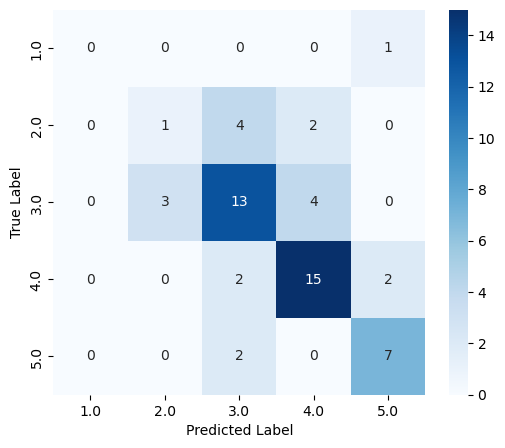

In [10]:
svm_original, svm_original_train_metrics, svm_original_test_metrics = apply_classifier(
    X_train, y_train, X_test, y_test, "Original", 'svm'
)

svm_smote, svm_smote_train_metrics, svm_smote_test_metrics = apply_classifier(
    X_train_smote, y_train_smote, X_test, y_test, "SMOTE", 'svm'
)

svm_bsmote1, svm_bsmote1_train_metrics, svm_bsmote1_test_metrics = apply_classifier(
    X_train_bsmote1, y_train_bsmote1, X_test, y_test, "Borderline-SMOTE1", 'svm'
)

svm_bsmote2, svm_bsmote2_train_metrics, svm_bsmote2_test_metrics = apply_classifier(
    X_train_bsmote2, y_train_bsmote2, X_test, y_test, "Borderline-SMOTE2", 'svm'
)


KNN без балансировки
Лучшие параметры KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Оценка на обучающей выборке:
KNN Train (Original):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00        26
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        76
         5.0       1.00      1.00      1.00        34

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



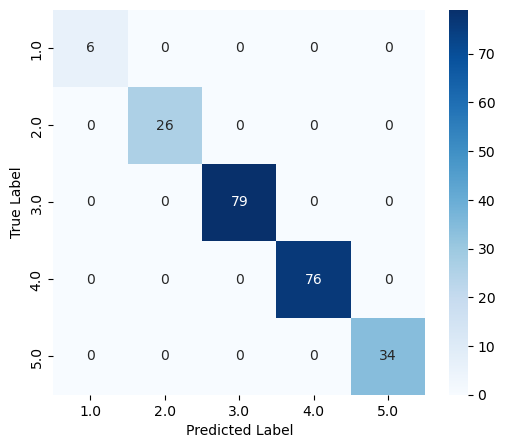


Оценка на тестовой выборке:
KNN Test (Original):
  Accuracy:  0.6250
  Recall:    0.6250
  Precision: 0.6077
  F1-score:  0.6137
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.40      0.29      0.33         7
         3.0       0.55      0.60      0.57        20
         4.0       0.71      0.79      0.75        19
         5.0       0.75      0.67      0.71         9

    accuracy                           0.62        56
   macro avg       0.48      0.47      0.47        56
weighted avg       0.61      0.62      0.61        56



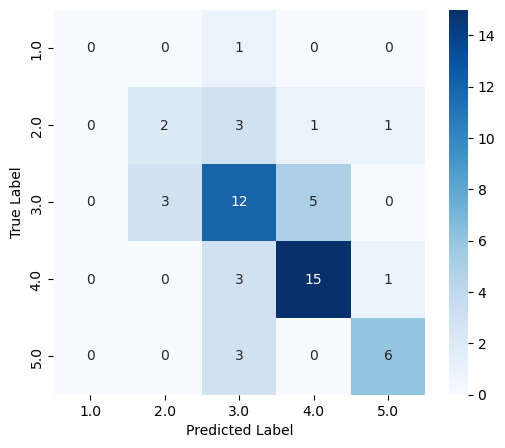


KNN c SMOTE
Лучшие параметры KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Оценка на обучающей выборке:
KNN Train (SMOTE):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        79
         5.0       1.00      1.00      1.00        79

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



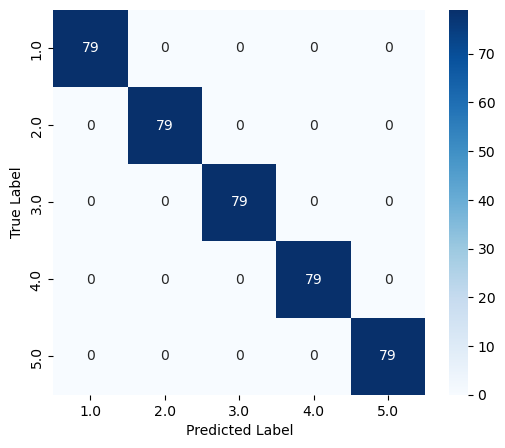


Оценка на тестовой выборке:
KNN Test (SMOTE):
  Accuracy:  0.6786
  Recall:    0.6786
  Precision: 0.6850
  F1-score:  0.6768
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.40      0.57      0.47         7
         3.0       0.76      0.65      0.70        20
         4.0       0.72      0.68      0.70        19
         5.0       0.73      0.89      0.80         9

    accuracy                           0.68        56
   macro avg       0.52      0.56      0.54        56
weighted avg       0.69      0.68      0.68        56



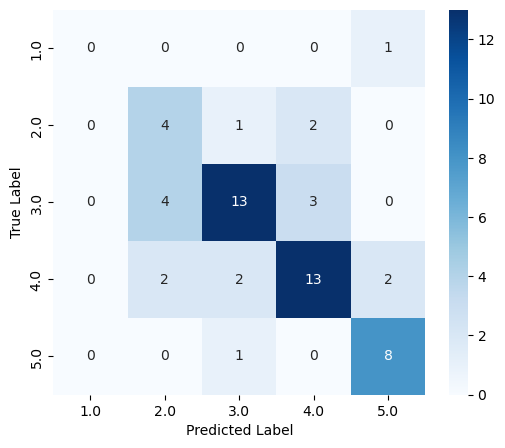


KNN c Borderline-SMOTE1
Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Оценка на обучающей выборке:
KNN Train (Borderline-SMOTE1):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        79
         5.0       1.00      1.00      1.00        79

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



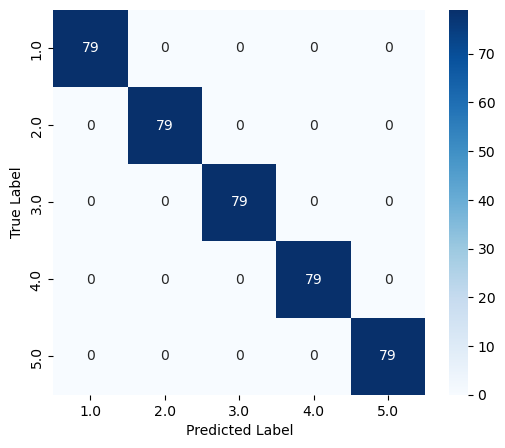


Оценка на тестовой выборке:
KNN Test (Borderline-SMOTE1):
  Accuracy:  0.5357
  Recall:    0.5357
  Precision: 0.6107
  F1-score:  0.5524
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.11      0.14      0.12         7
         3.0       0.83      0.50      0.62        20
         4.0       0.61      0.58      0.59        19
         5.0       0.57      0.89      0.70         9

    accuracy                           0.54        56
   macro avg       0.43      0.42      0.41        56
weighted avg       0.61      0.54      0.55        56



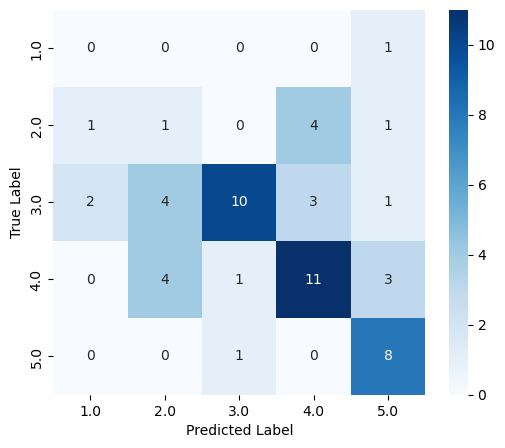


KNN c Borderline-SMOTE2
Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

Оценка на обучающей выборке:
KNN Train (Borderline-SMOTE2):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        79
         5.0       1.00      1.00      1.00        79

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



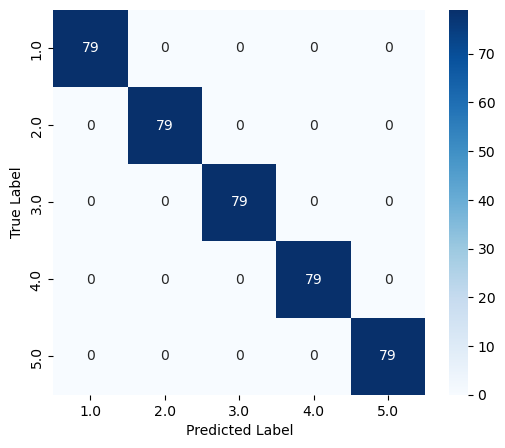


Оценка на тестовой выборке:
KNN Test (Borderline-SMOTE2):
  Accuracy:  0.5893
  Recall:    0.5893
  Precision: 0.6202
  F1-score:  0.5964
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.20      0.29      0.24         7
         3.0       0.73      0.55      0.63        20
         4.0       0.67      0.63      0.65        19
         5.0       0.67      0.89      0.76         9

    accuracy                           0.59        56
   macro avg       0.45      0.47      0.45        56
weighted avg       0.62      0.59      0.60        56



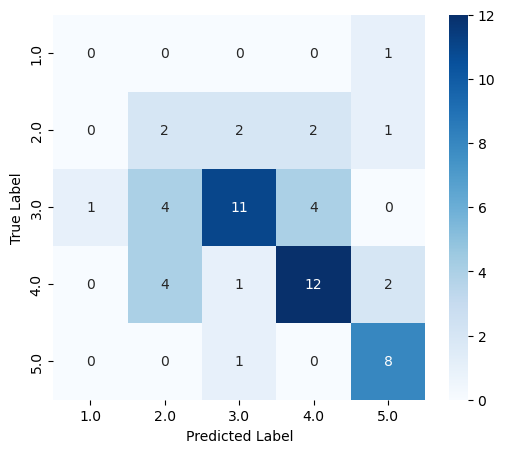

In [11]:
knn_original, knn_original_train_metrics, knn_original_test_metrics = apply_classifier(
    X_train, y_train, X_test, y_test, "Original", 'knn'
)

knn_smote, knn_smote_train_metrics, knn_smote_test_metrics = apply_classifier(
    X_train_smote, y_train_smote, X_test, y_test, "SMOTE", 'knn'
)

knn_bsmote1, knn_bsmote1_train_metrics, knn_bsmote1_test_metrics = apply_classifier(
    X_train_bsmote1, y_train_bsmote1, X_test, y_test, "Borderline-SMOTE1", 'knn'
)

knn_bsmote2, knn_bsmote2_train_metrics, knn_bsmote2_test_metrics = apply_classifier(
    X_train_bsmote2, y_train_bsmote2, X_test, y_test, "Borderline-SMOTE2", 'knn'
)



Random Forest без балансировки
Лучшие параметры Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Оценка на обучающей выборке:
Random Forest Train (Original):
  Accuracy:  0.9819
  Recall:    0.9819
  Precision: 0.9827
  F1-score:  0.9818
              precision    recall  f1-score   support

         1.0       1.00      0.83      0.91         6
         2.0       0.93      1.00      0.96        26
         3.0       1.00      0.97      0.99        79
         4.0       0.99      0.99      0.99        76
         5.0       0.97      1.00      0.99        34

    accuracy                           0.98       221
   macro avg       0.98      0.96      0.97       221
weighted avg       0.98      0.98      0.98       221



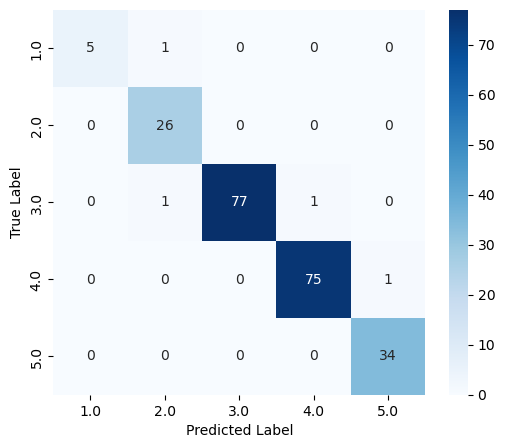


Оценка на тестовой выборке:
Random Forest Test (Original):
  Accuracy:  0.5893
  Recall:    0.5893
  Precision: 0.5854
  F1-score:  0.5758
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.67      0.29      0.40         7
         3.0       0.58      0.70      0.64        20
         4.0       0.55      0.58      0.56        19
         5.0       0.67      0.67      0.67         9

    accuracy                           0.59        56
   macro avg       0.49      0.45      0.45        56
weighted avg       0.59      0.59      0.58        56



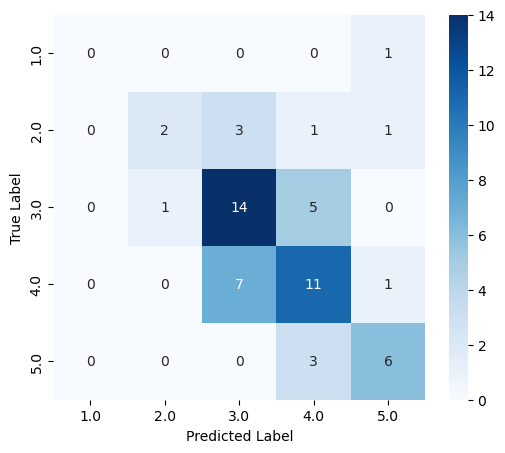


Random Forest c SMOTE
Лучшие параметры Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

Оценка на обучающей выборке:
Random Forest Train (SMOTE):
  Accuracy:  0.9949
  Recall:    0.9949
  Precision: 0.9949
  F1-score:  0.9949
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       0.99      0.99      0.99        79
         5.0       0.99      0.99      0.99        79

    accuracy                           0.99       395
   macro avg       0.99      0.99      0.99       395
weighted avg       0.99      0.99      0.99       395



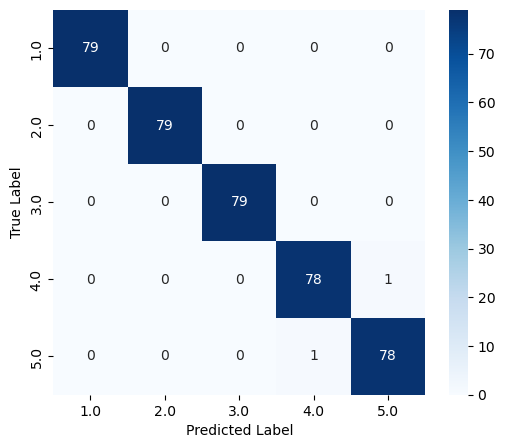


Оценка на тестовой выборке:
Random Forest Test (SMOTE):
  Accuracy:  0.6250
  Recall:    0.6250
  Precision: 0.6441
  F1-score:  0.6323
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.43      0.43      0.43         7
         3.0       0.59      0.65      0.62        20
         4.0       0.75      0.63      0.69        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.62        56
   macro avg       0.51      0.50      0.50        56
weighted avg       0.64      0.62      0.63        56



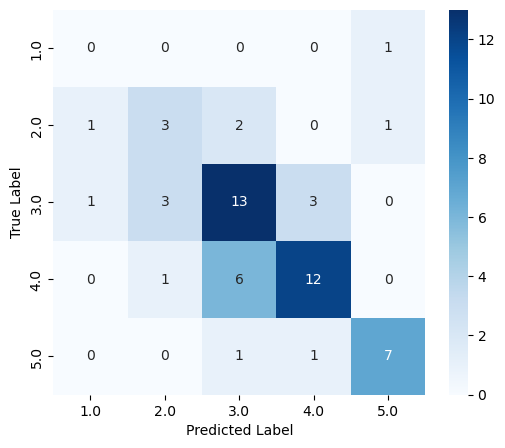


Random Forest c Borderline-SMOTE1
Лучшие параметры Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Оценка на обучающей выборке:
Random Forest Train (Borderline-SMOTE1):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        79
         5.0       1.00      1.00      1.00        79

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



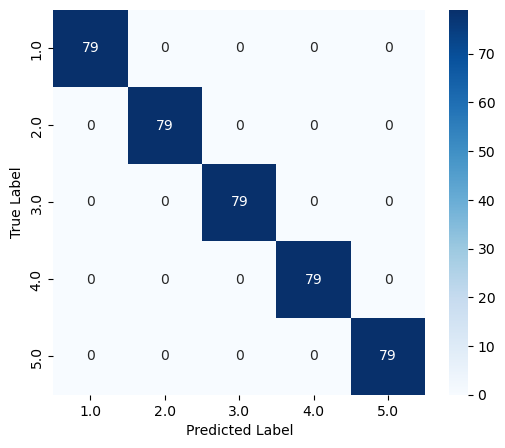


Оценка на тестовой выборке:
Random Forest Test (Borderline-SMOTE1):
  Accuracy:  0.6250
  Recall:    0.6250
  Precision: 0.6215
  F1-score:  0.6185
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.50      0.29      0.36         7
         3.0       0.57      0.65      0.60        20
         4.0       0.68      0.68      0.68        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.62        56
   macro avg       0.51      0.48      0.49        56
weighted avg       0.62      0.62      0.62        56



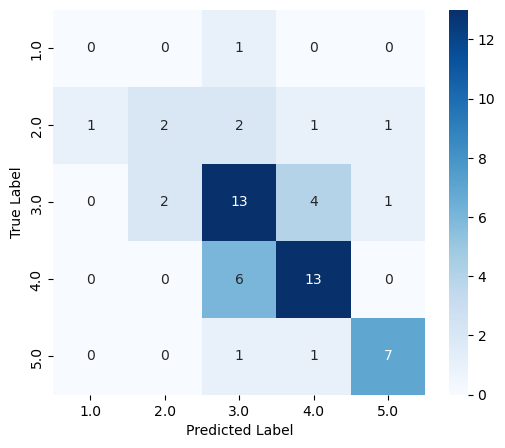


Random Forest c Borderline-SMOTE2
Лучшие параметры Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Оценка на обучающей выборке:
Random Forest Train (Borderline-SMOTE2):
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        79
         2.0       1.00      1.00      1.00        79
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        79
         5.0       1.00      1.00      1.00        79

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



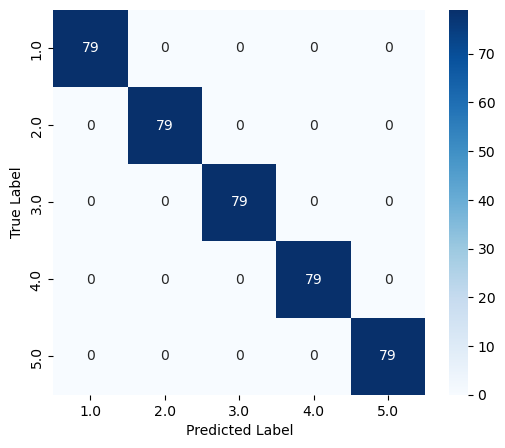


Оценка на тестовой выборке:
Random Forest Test (Borderline-SMOTE2):
  Accuracy:  0.6786
  Recall:    0.6786
  Precision: 0.6667
  F1-score:  0.6725
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.57      0.57      0.57         7
         3.0       0.67      0.70      0.68        20
         4.0       0.68      0.68      0.68        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.68        56
   macro avg       0.54      0.55      0.54        56
weighted avg       0.67      0.68      0.67        56



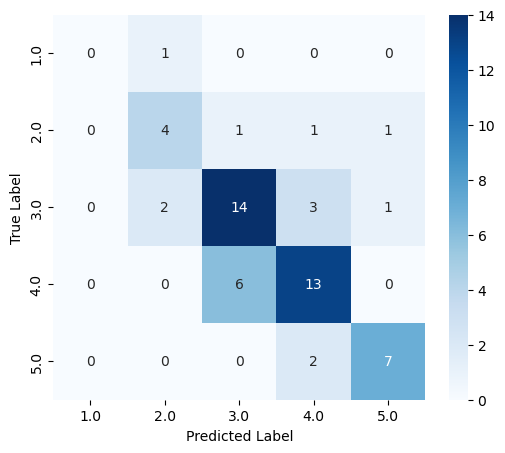

In [12]:
rf_original, rf_original_train_metrics, rf_original_test_metrics = apply_classifier(
    X_train, y_train, X_test, y_test, "Original", 'rf'
)

rf_smote, rf_smote_train_metrics, rf_smote_test_metrics = apply_classifier(
    X_train_smote, y_train_smote, X_test, y_test, "SMOTE", 'rf'
)

rf_bsmote1, rf_bsmote1_train_metrics, rf_bsmote1_test_metrics = apply_classifier(
    X_train_bsmote1, y_train_bsmote1, X_test, y_test, "Borderline-SMOTE1", 'rf'
)

rf_bsmote2, rf_bsmote2_train_metrics, rf_bsmote2_test_metrics = apply_classifier(
    X_train_bsmote2, y_train_bsmote2, X_test, y_test, "Borderline-SMOTE2", 'rf'
)

In [13]:
results_data = []

def add_results(model_name, balance_method, train_metrics, test_metrics):
    results_data.append({
        'Model': model_name,
        'Balance Method': balance_method,
        'Train Accuracy': train_metrics[0],
        'Train Recall': train_metrics[1],
        'Train Precision': train_metrics[2],
        'Train F1': train_metrics[3],
        'Test Accuracy': test_metrics[0],
        'Test Recall': test_metrics[1],
        'Test Precision': test_metrics[2],
        'Test F1': test_metrics[3]
    })

add_results('SVM', 'None', svm_original_train_metrics, svm_original_test_metrics)
add_results('SVM', 'SMOTE', svm_smote_train_metrics, svm_smote_test_metrics)
add_results('SVM', 'Borderline-SMOTE1', svm_bsmote1_train_metrics, svm_bsmote1_test_metrics)
add_results('SVM', 'Borderline-SMOTE2', svm_bsmote2_train_metrics, svm_bsmote2_test_metrics)

add_results('KNN', 'None', knn_original_train_metrics, knn_original_test_metrics)
add_results('KNN', 'SMOTE', knn_smote_train_metrics, knn_smote_test_metrics)
add_results('KNN', 'Borderline-SMOTE1', knn_bsmote1_train_metrics, knn_bsmote1_test_metrics)
add_results('KNN', 'Borderline-SMOTE2', knn_bsmote2_train_metrics, knn_bsmote2_test_metrics)

add_results('Random Forest', 'None', rf_original_train_metrics, rf_original_test_metrics)
add_results('Random Forest', 'SMOTE', rf_smote_train_metrics, rf_smote_test_metrics)
add_results('Random Forest', 'Borderline-SMOTE1', rf_bsmote1_train_metrics, rf_bsmote1_test_metrics)
add_results('Random Forest', 'Borderline-SMOTE2', rf_bsmote2_train_metrics, rf_bsmote2_test_metrics)

results_df = pd.DataFrame(results_data)
# results_df
results_df.sort_values(['Test F1'], ascending=False)

,Model,Balance Method,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
5,KNN,SMOTE,1.000000,1.000000,1.000000,1.000000,0.678571,0.678571,0.685032,0.676777
11,Random Forest,Borderline-SMOTE2,1.000000,1.000000,1.000000,1.000000,0.678571,0.678571,0.666667,0.672474
1,SVM,SMOTE,0.977215,0.977215,0.977077,0.977069,0.660714,0.660714,0.635146,0.644678
9,Random Forest,SMOTE,0.994937,0.994937,0.994937,0.994937,0.625000,0.625000,0.644075,0.632313
2,SVM,Borderline-SMOTE1,0.979747,0.979747,0.979808,0.979746,0.642857,0.642857,0.619685,0.628672
0,SVM,None,0.932127,0.932127,0.931908,0.931972,0.642857,0.642857,0.609636,0.623280
3,SVM,Borderline-SMOTE2,0.977215,0.977215,0.977176,0.977149,0.642857,0.642857,0.607185,0.622093
10,Random Forest,Borderline-SMOTE1,1.000000,1.000000,1.000000,1.000000,0.625000,0.625000,0.621506,0.618544
4,KNN,None,1.000000,1.000000,1.000000,1.000000,0.625000,0.625000,0.607688,0.613658
7,KNN,Borderline-SMOTE2,1.000000,1.000000,1.000000,1.000000,0.589286,0.589286,0.620238,0.596428


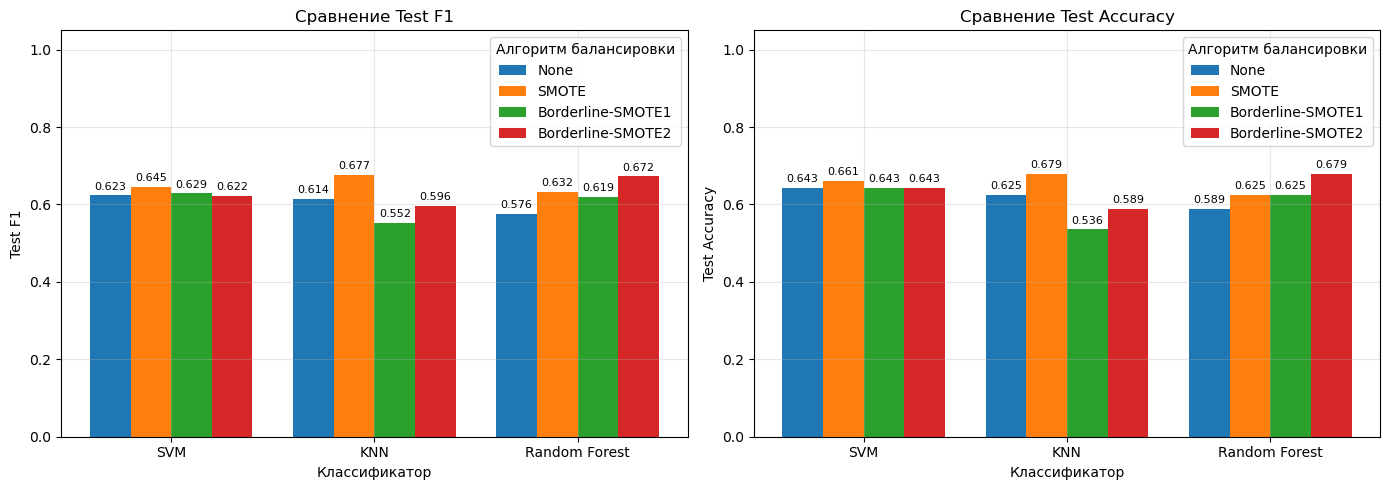

In [14]:
models = ['SVM', 'KNN', 'Random Forest']
balance_methods = ['None', 'SMOTE', 'Borderline-SMOTE1', 'Borderline-SMOTE2']

# metrics_to_plot = ['Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1']
metrics_to_plot = ['Test F1', 'Test Accuracy']
# metrics_to_plot = ['Test F1']

n_metrics = len(metrics_to_plot)
n_cols = 2 if n_metrics >=2 else 1
n_rows = math.ceil(n_metrics/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, 5 * n_rows))

for idx, metric in enumerate(metrics_to_plot):
    if n_metrics == 1:
        ax = axes
    elif n_rows == 1:
        ax = axes[idx % 2]
    else:
        ax = axes[idx // 2, idx % 2]
    
    metric_data = {method: [] for method in balance_methods}
    
    for model in models:
        for balance_method in balance_methods:
            value = results_df[(results_df['Model'] == model) & 
                              (results_df['Balance Method'] == balance_method)][metric].values[0]
            metric_data[balance_method].append(value)
    
    x = np.arange(len(models))
    width = 0.2
    
    for i, (method, values) in enumerate(metric_data.items()):
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, values, width, label=method)
        
        for bar_idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Классификатор')
    ax.set_ylabel(metric)
    ax.set_title(f'Сравнение {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(title='Алгоритм балансировки')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [15]:
for model in models:
    model_results = results_df[results_df['Model'] == model]
    
    best_f1_idx = model_results['Test F1'].idxmax()
    best_method = model_results.loc[best_f1_idx, 'Balance Method']
    best_f1 = model_results.loc[best_f1_idx, 'Test F1']
    
    best_acc_idx = model_results['Test Accuracy'].idxmax()
    best_acc_method = model_results.loc[best_acc_idx, 'Balance Method']
    best_acc = model_results.loc[best_acc_idx, 'Test Accuracy']
    
    print(f"\n{model}:")
    print(f"\tЛучший алгоритм по F1-score: {best_method} (F1 = {best_f1:.4f})")
    print(f"\tЛучший алгоритм по Accuracy: {best_acc_method} (Accuracy = {best_acc:.4f})")


SVM:
	Лучший алгоритм по F1-score: SMOTE (F1 = 0.6447)
	Лучший алгоритм по Accuracy: SMOTE (Accuracy = 0.6607)

KNN:
	Лучший алгоритм по F1-score: SMOTE (F1 = 0.6768)
	Лучший алгоритм по Accuracy: SMOTE (Accuracy = 0.6786)

Random Forest:
	Лучший алгоритм по F1-score: Borderline-SMOTE2 (F1 = 0.6725)
	Лучший алгоритм по Accuracy: Borderline-SMOTE2 (Accuracy = 0.6786)


In [16]:
balance_evaluation = []
for method in balance_methods:
    method_results = results_df[results_df['Balance Method'] == method]
    avg_f1 = method_results['Test F1'].mean()
    avg_acc = method_results['Test Accuracy'].mean()
    avg_recall = method_results['Test Recall'].mean()
    avg_precision = method_results['Test Precision'].mean()
    
    balance_evaluation.append({
        'Method': method,
        'Avg F1': avg_f1,
        'Avg Accuracy': avg_acc,
        'Avg Recall': avg_recall,
        'Avg Precision': avg_precision
    })

balance_df = pd.DataFrame(balance_evaluation)
balance_df.sort_values(['Avg F1'], ascending=False)

,Method,Avg F1,Avg Accuracy,Avg Recall,Avg Precision
1,SMOTE,0.651256,0.654762,0.654762,0.654751
3,Borderline-SMOTE2,0.630332,0.636905,0.636905,0.631363
0,None,0.604248,0.619048,0.619048,0.600913
2,Borderline-SMOTE1,0.599865,0.601190,0.601190,0.617293


## Визуализация

Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP 
(при различных сочетаниях значений их параметров): изобразить объекты 
разных классов разным цветом (разным маркерами). 

Сделать рисунки разбиения на классы на основе выборок с известными 
метками классов и рисунки разбиения на классы с метками выставленными 
классификатором. 

In [17]:
best_overall_idx = results_df['Test F1'].idxmax()
best_model_name = results_df.loc[best_overall_idx, 'Model']
best_balance_method = results_df.loc[best_overall_idx, 'Balance Method']

print(f"Лучшая модель: {best_model_name} с алгоритмом балансировки {best_balance_method}")

Лучшая модель: KNN с алгоритмом балансировки SMOTE


In [18]:
if best_model_name == 'SVM':
    if best_balance_method == 'None':
        best_model = svm_original
        X_train_best = X_train
        y_train_best = y_train
    elif best_balance_method == 'SMOTE':
        best_model = svm_smote
        X_train_best = X_train_smote
        y_train_best = y_train_smote
    elif best_balance_method == 'Borderline-SMOTE1':
        best_model = svm_bsmote1
        X_train_best = X_train_bsmote1
        y_train_best = y_train_bsmote1
    else:
        best_model = svm_bsmote2
        X_train_best = X_train_bsmote2
        y_train_best = y_train_bsmote2
        
elif best_model_name == 'KNN':
    if best_balance_method == 'None':
        best_model = knn_original
        X_train_best = X_train
        y_train_best = y_train
    elif best_balance_method == 'SMOTE':
        best_model = knn_smote
        X_train_best = X_train_smote
        y_train_best = y_train_smote
    elif best_balance_method == 'Borderline-SMOTE1':
        best_model = knn_bsmote1
        X_train_best = X_train_bsmote1
        y_train_best = y_train_bsmote1
    else:
        best_model = knn_bsmote2
        X_train_best = X_train_bsmote2
        y_train_best = y_train_bsmote2
        
else:  # Random Forest
    if best_balance_method == 'None':
        best_model = rf_original
        X_train_best = X_train
        y_train_best = y_train
    elif best_balance_method == 'SMOTE':
        best_model = rf_smote
        X_train_best = X_train_smote
        y_train_best = y_train_smote
    elif best_balance_method == 'Borderline-SMOTE1':
        best_model = rf_bsmote1
        X_train_best = X_train_bsmote1
        y_train_best = y_train_bsmote1
    else:
        best_model = rf_bsmote2
        X_train_best = X_train_bsmote2
        y_train_best = y_train_bsmote2
        
if best_model_name == 'SVM':
    support_vectors_idx = best_model.support_
else:
    support_vectors_idx = None

In [19]:
def visualize(X_data, y_true, y_pred, model_name, support_vectors_idx=None):
    reducers = {
        't-SNE': [
            {'n_components': 2, 'perplexity': 5, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 15, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 30, 'learning_rate': 200}
        ],
        'UMAP': [
            {'n_components': 2, 'n_neighbors': 5, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0.1}
        ],
        'TriMAP': [
            {'n_dims': 2, 'n_inliers': 10, 'n_outliers': 5},
            {'n_dims': 2, 'n_inliers': 20, 'n_outliers': 10},
            {'n_dims': 2, 'n_inliers': 30, 'n_outliers': 15}
        ],
        'PaCMAP': [
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 20, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.8, 'FP_ratio': 2.0}
        ]
    }
    
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    colors = ['#FF0000', '#FF5500', '#FFAA00', '#AAFF00', '#00FF00']  
    cmap_gradient = ListedColormap(colors)
    
    for method_name, param_combinations in reducers.items():
        num_combinations = len(param_combinations)
        fig, axes = plt.subplots(2, num_combinations, 
                                 figsize=(5*num_combinations, 10))

        for i, params in enumerate(param_combinations):
            try:
                if method_name == 't-SNE':
                    reducer = TSNE(**params, random_state=42)
                elif method_name == 'UMAP':
                    reducer = umap.UMAP(**params, random_state=42)
                elif method_name == 'TriMAP':
                    reducer = trimap.TRIMAP(**params)
                elif method_name == 'PaCMAP':
                    reducer = pacmap.PaCMAP(**params)
                else:
                    continue

                # Применяем редукцию
                X_emb = reducer.fit_transform(X_data)

                # Истинные метки
                ax1 = axes[0, i] if num_combinations > 1 else axes[0]
                param_title = '\n'.join([f"{key} = {value}" for key, value in params.items()])
                scatter1 = ax1.scatter(X_emb[:, 0], X_emb[:, 1], c=y_true, 
                                       cmap=cmap_gradient, alpha=0.7, s=50,
                                       vmin=min(unique_classes)-0.5, vmax=max(unique_classes)+0.5)
                ax1.set_title(param_title)
                ax1.set_xlabel("Component 1")
                ax1.set_ylabel("Component 2")
                plt.colorbar(scatter1, ax=ax1)

                # Предсказанные метки
                ax2 = axes[1, i] if num_combinations > 1 else axes[1]
                scatter2 = ax2.scatter(X_emb[:, 0], X_emb[:, 1], c=y_pred,
                                       cmap=cmap_gradient, alpha=0.7, s=50,
                                       vmin=min(unique_classes)-0.5, vmax=max(unique_classes)+0.5)
                ax2.set_title("Предсказания")
                ax2.set_xlabel("Component 1")
                ax2.set_ylabel("Component 2")
                plt.colorbar(scatter2, ax=ax2)

                # Опорные векторы (если есть)
                if support_vectors_idx is not None and len(support_vectors_idx) > 0:
                    # Используем только те опорные векторы, которые есть в X_emb
                    sv_indices_in_emb = [idx for idx in support_vectors_idx if idx < len(X_emb)]
                    if sv_indices_in_emb:
                        support_vectors_emb = X_emb[sv_indices_in_emb, :]
                        ax1.scatter(support_vectors_emb[:, 0], support_vectors_emb[:, 1], 
                                    s=150, facecolors='none', edgecolors='red', linewidths=1, 
                                    label=f'Опорные векторы ({len(sv_indices_in_emb)})')
                        ax2.scatter(support_vectors_emb[:, 0], support_vectors_emb[:, 1], 
                                    s=150, facecolors='none', edgecolors='red', linewidths=1, 
                                    label=f'Опорные векторы ({len(sv_indices_in_emb)})')
                        ax1.legend()
                        ax2.legend()

            except Exception as e:
                print(f"Ошибка при визуализации с параметрами {params}: {e}")

        plt.suptitle(f"\nВизуализация {model_name} с помощью {method_name}", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

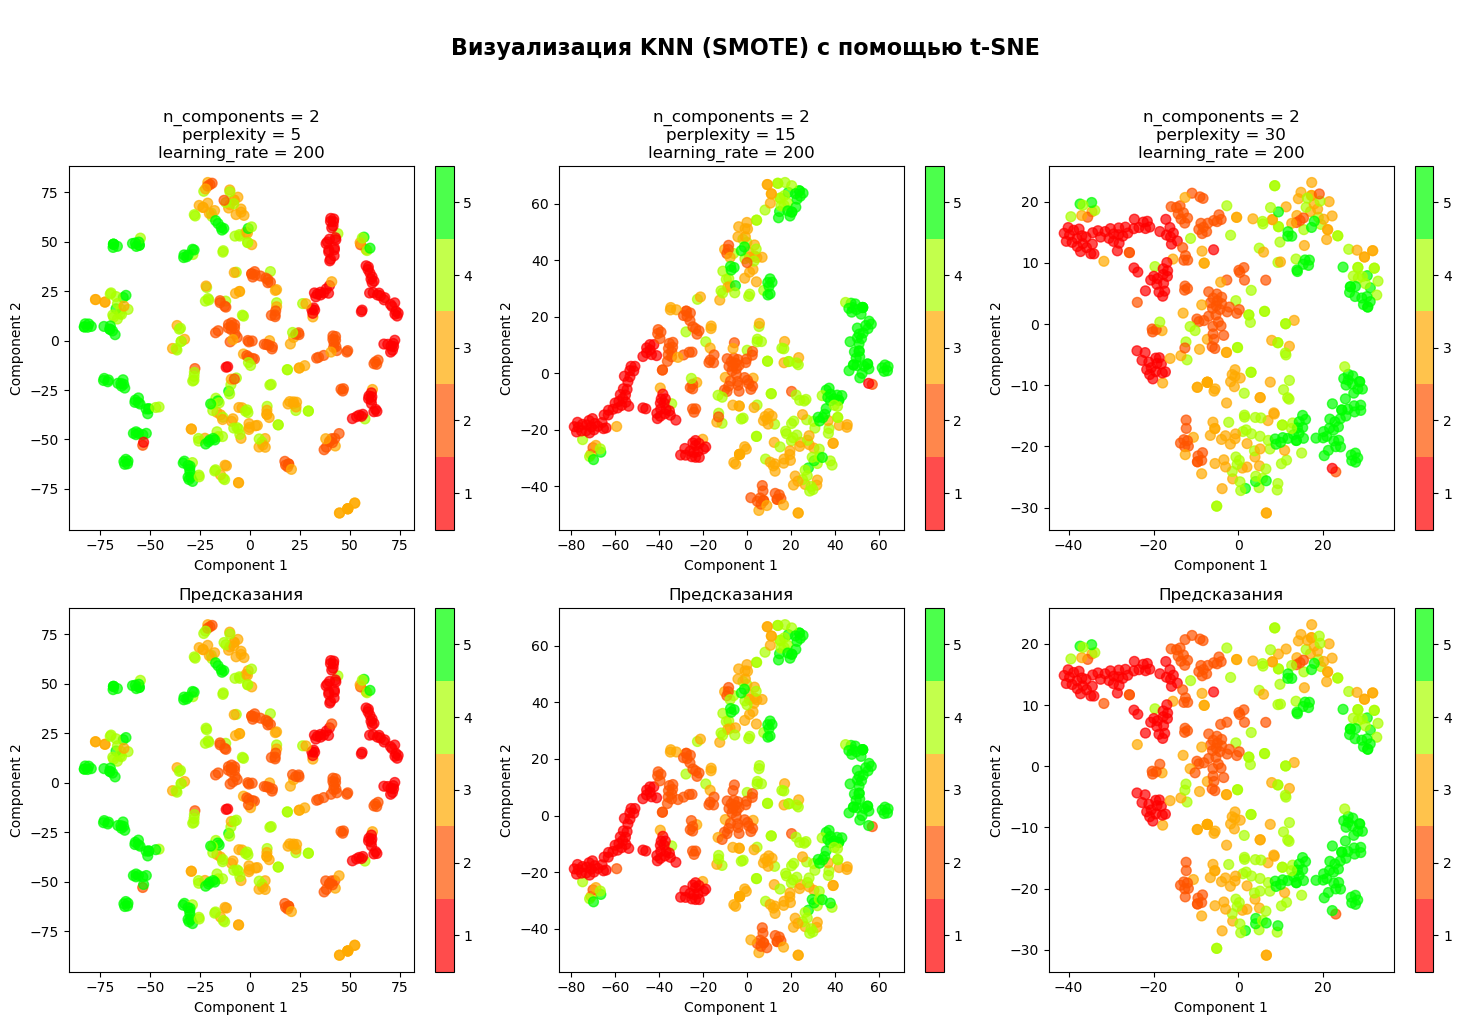

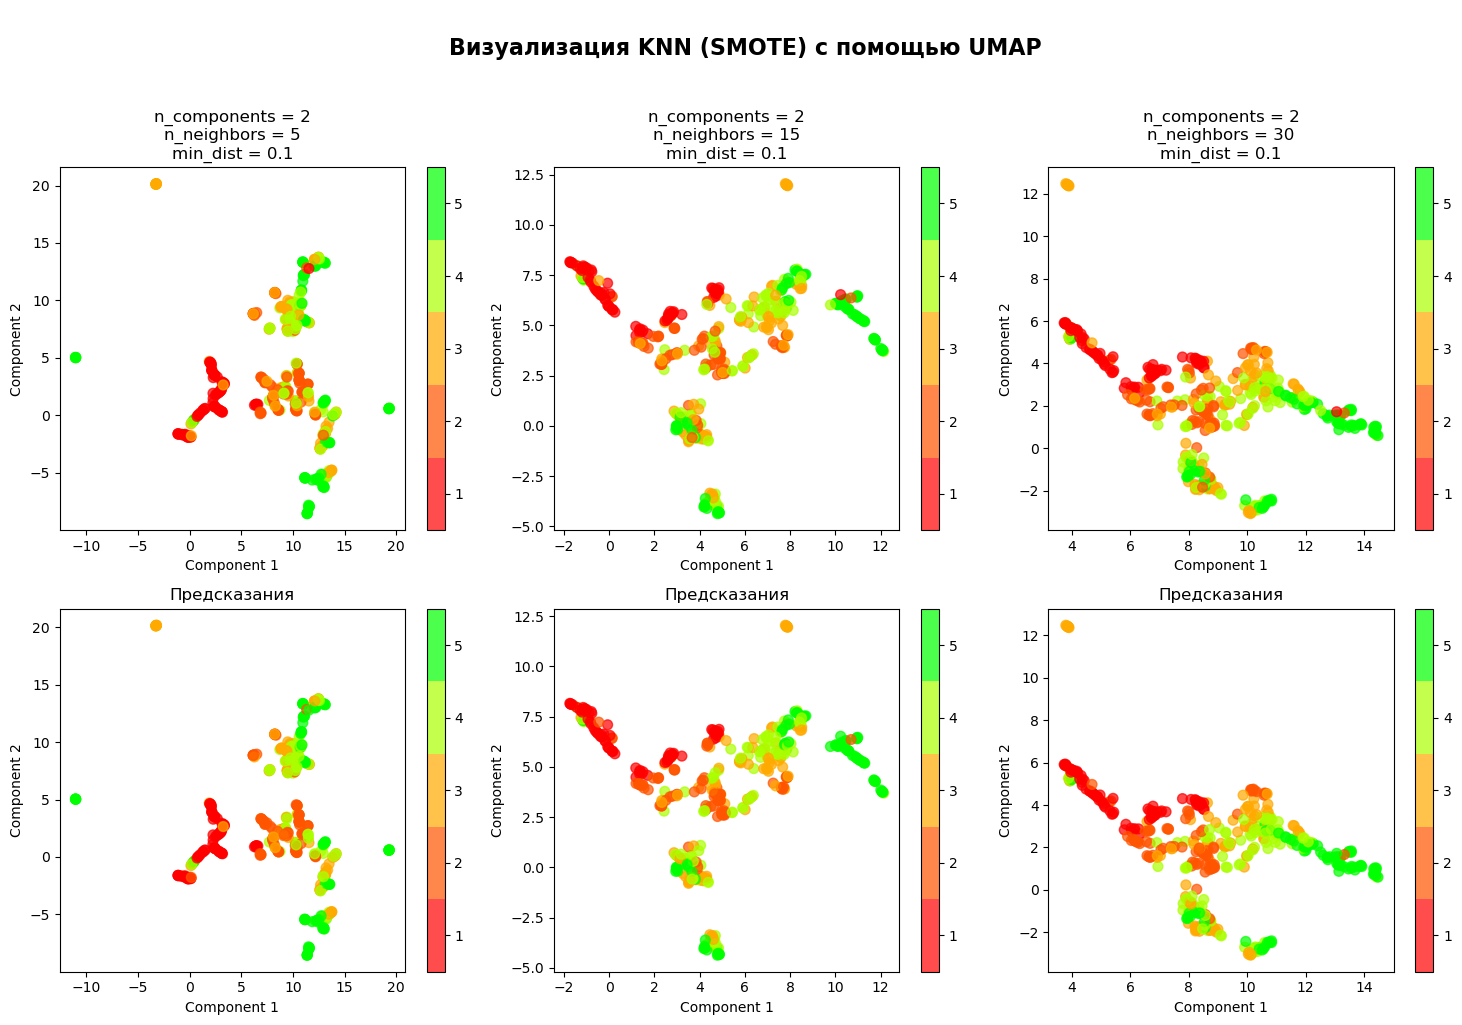

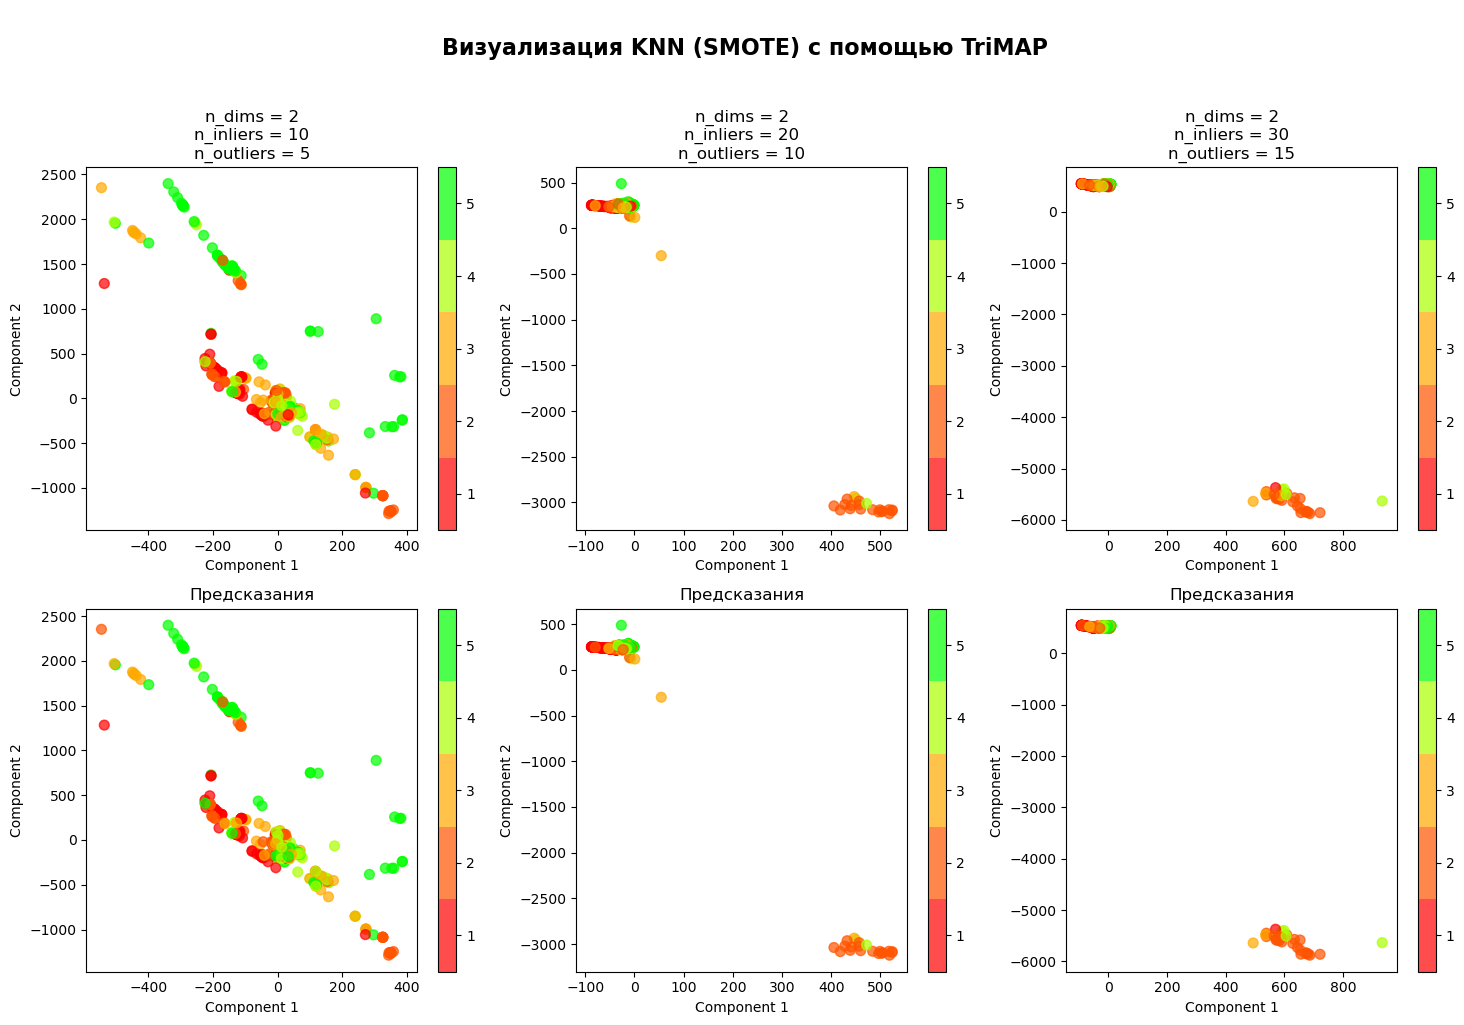

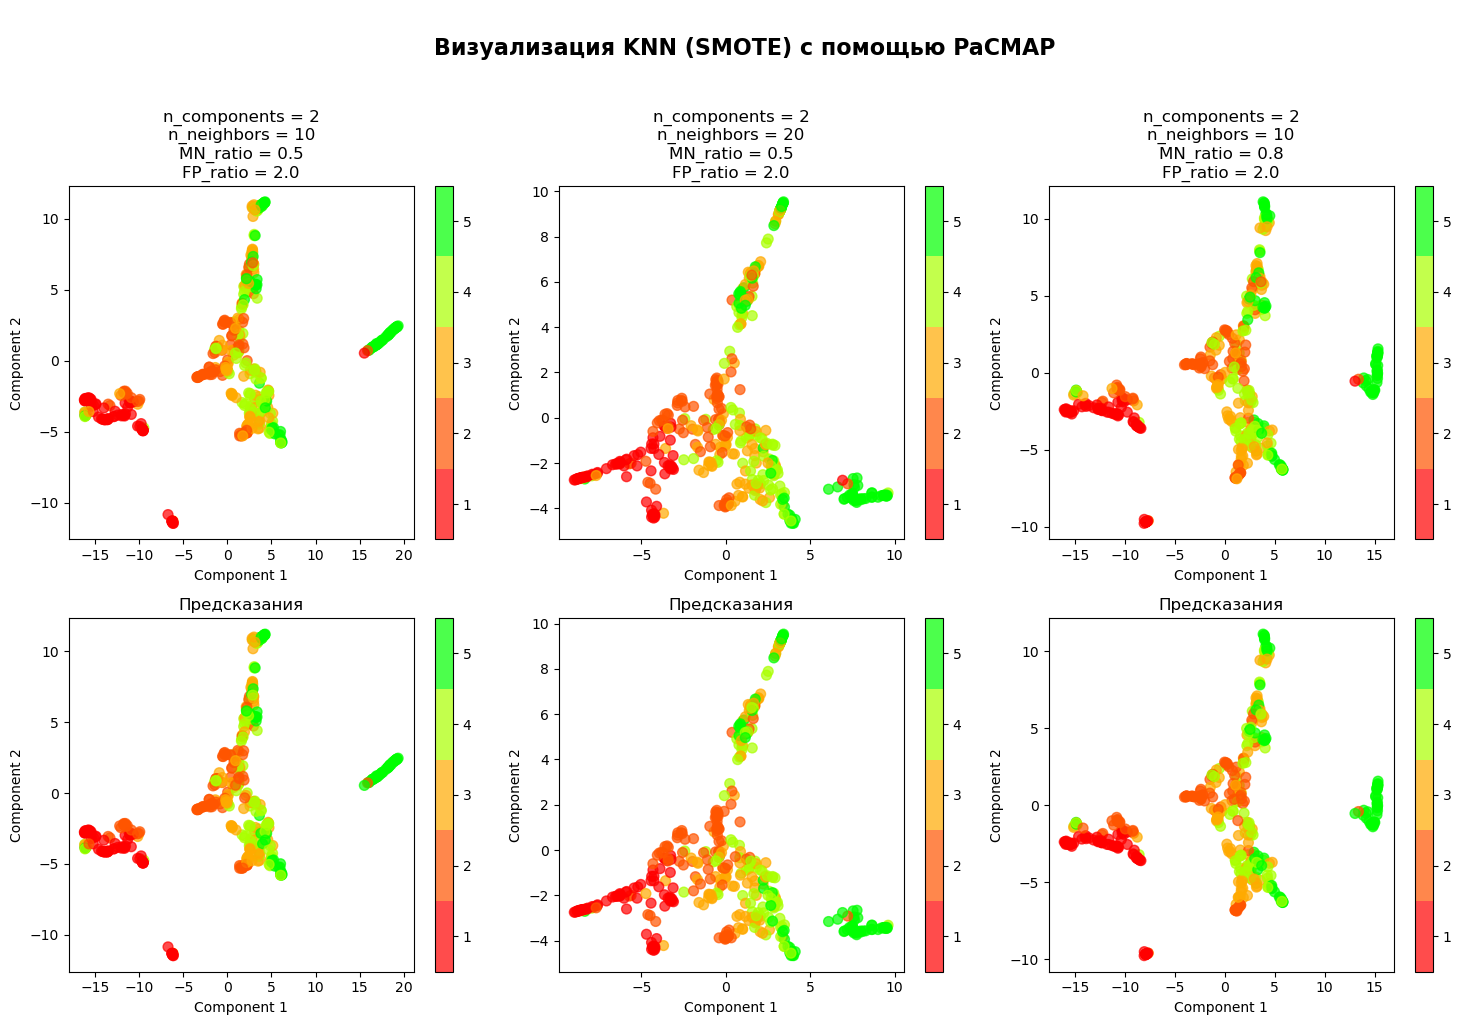

In [20]:
X_combined = np.vstack([X_train_best, X_test])
y_combined_true = np.concatenate([y_train_best, y_test])
y_combined_pred = best_model.predict(X_combined)

visualize(X_combined, y_combined_true, y_combined_pred, 
          f"{best_model_name} ({best_balance_method})", support_vectors_idx)